In [2]:
!pip install torch

In [4]:
!pip install kaggle

In [3]:
!pip install torchvision

In [4]:
!pip install tensorflow

In [34]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [35]:
import tensorflow as tf
import numpy as np

def set_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [49]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

set_seeds(42)
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

In [9]:
!pip install torchinfo

In [38]:
from torchinfo import summary

summary(model = pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [50]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [51]:
train_dir = "D:/Gucci/MCA/Semester 2/PDT/dataset/Training"
test_dir = "D:/Gucci/MCA/Semester 2/PDT/dataset/Testing"

In [52]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS):
    
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    class_names = train_data.classes
    
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True)
    
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True)
    
    return train_dataloader, test_dataloader, class_names

In [53]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir = train_dir, test_dir = test_dir, transform = pretrained_vit_transforms, batch_size=32)

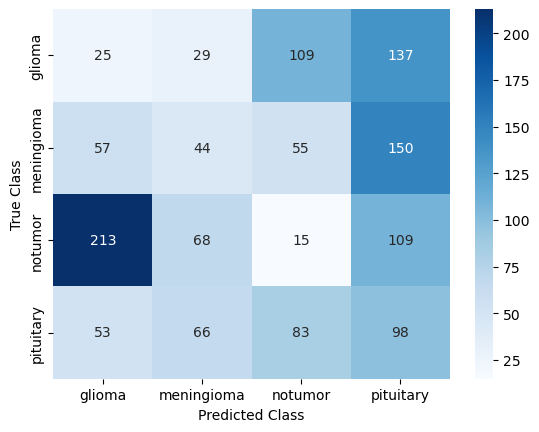

In [55]:
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt

pretrained_vit.eval()

true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader_pretrained:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = pretrained_vit(inputs)

        _, predicted = torch.max(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

class_labels = ["glioma", "meningioma", "notumor", "pituitary"]

sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)

# Print precision, recall, F1-score, and AUC for each class
for i, label in enumerate(class_labels):
    print(f"\nClass: {label}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-score: {f1[i]}")
    #print(f"AUC: {auc_scores[i]}\n")

# Calculate and print overall metrics
overall_precision = precision_score(true_labels, predictions, average='weighted')
overall_recall = recall_score(true_labels, predictions, average='weighted')
overall_f1 = f1_score(true_labels, predictions, average='weighted')

print("\nOverall Metrics:")
print(f"Precision: {overall_precision}")
print(f"Recall: {overall_recall}")
print(f"F1-score: {overall_f1}")



Class: glioma
Precision: 0.07183908045977011
Recall: 0.08333333333333333
F1-score: 0.0771604938271605

Class: meningioma
Precision: 0.21256038647342995
Recall: 0.1437908496732026
F1-score: 0.17153996101364521

Class: notumor
Precision: 0.05725190839694656
Recall: 0.037037037037037035
F1-score: 0.04497751124437781

Class: pituitary
Precision: 0.19838056680161945
Recall: 0.32666666666666666
F1-score: 0.24685138539042825

Overall Metrics:
Precision: 0.12913531299774966
Recall: 0.13882532418001525
F1-score: 0.1280783248584478


In [57]:
import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

set_seeds(42)
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [58]:
torch.save(pretrained_vit.state_dict(), 'vision_transformer_model.pth')